In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
weather = pd.read_csv('fullweather.csv')

In [3]:
weather['Local time in Jeju (airport)'] = pd.to_datetime(weather['Local time in Jeju (airport)'], format='%Y-%m-%d %H:%M', errors='raise')
weather['Date'] = weather['Local time in Jeju (airport)'].dt.date
weather['WW'][weather['WW'].notnull()] = 1
weather['WW'][weather['WW'].isnull()] = 0
weather['WW'] = pd.to_numeric(weather['WW'])


C:\Users\mllab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mllab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
temp_rain = weather.groupby('Date',as_index=False).mean()
temp_rain.rename(columns={'WW':'rain'},inplace=True)
temp_rain['Date'] = temp_rain['Date'].astype(str)

In [5]:
weather

,Local time in Jeju (airport),T,WW,Date
0,2019-04-16 01:00:00,11.6,0.0,2019-04-16
1,2019-04-16 02:00:00,11.4,0.0,2019-04-16
2,2019-04-16 03:00:00,11.4,0.0,2019-04-16
3,2019-04-16 04:00:00,11.1,0.0,2019-04-16
4,2019-04-16 05:00:00,11.2,0.0,2019-04-16
...,...,...,...,...
74759,2021-06-02 20:00:00,22.0,0.0,2021-06-02
74760,2021-06-02 21:00:00,22.0,0.0,2021-06-02
74761,2021-06-02 22:00:00,22.1,0.0,2021-06-02
74762,2021-06-02 23:00:00,22.6,0.0,2021-06-02


In [6]:
data = pd.read_csv('./predata.csv')
data

,rent_date,rent_number,rent_station,year,month,day,day_name
0,2019-04-16,1,EVS_000003,2019,4,16,Tuesday
1,2019-04-20,2,EVS_000001,2019,4,20,Saturday
2,2019-04-21,2,EVS_000001,2019,4,21,Sunday
3,2019-04-24,2,EVS_000003,2019,4,24,Wednesday
4,2019-04-25,3,EVS_000003,2019,4,25,Thursday
...,...,...,...,...,...,...,...
4726,2020-10-15,2,EVS_000161,2020,10,15,Thursday
4727,2020-10-16,2,EVS_000161,2020,10,16,Friday
4728,2020-10-20,1,EVS_000206,2020,10,20,Tuesday
4729,2020-10-21,1,EVS_000206,2020,10,21,Wednesday


In [7]:
data = pd.read_csv('./predata.csv')
data.drop(['year','month'],axis=1,inplace=True)

In [8]:
place = pd.read_csv('station.csv', encoding='euc-kr') #길거리에 Iot 있는 킥보드가 있는 장소

In [9]:
data['Xpos'] = None
data['Ypos']= None

#위치 추가
for i in range(len(data)):
    for j in range(len(place)):
        if(data['rent_station'].iloc[i] == place['id'].iloc[j]):
            data['Xpos'].iloc[i] = float(round(place['x_pos'].iloc[j],3))
            data['Ypos'].iloc[i] = float(round(place['y_pos'].iloc[j],3))

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
data['Xpos'] = data['Xpos'].astype('float')
data['Ypos'] = data['Ypos'].astype('float')

In [11]:
#data = data.iloc[:4718] #10월 8일 이후 데이터 자르기위함

## 지역 여러개 데이터 분할

In [12]:
data['Sector'] = 0
NineSector_data = data.copy()
TwoSector_data = data.copy()
OneSector_data = data.copy()
FourSector_data = data.copy()

# ========================================================

In [13]:
def preprocessing(data):
    data['rent_date'] = pd.to_datetime(data['rent_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    data['year'] =data['rent_date'].dt.year
    data['month'] =data['rent_date'].dt.month
    data['day'] =data['rent_date'].dt.day
    data['day_name'] = data['rent_date'].dt.day_name()
    data = data.sort_values(by='rent_date')
    data['rent_date'] = data['rent_date'].astype(str)
    data['T'] = None
    data['rain'] = None
    return data

In [14]:
def temp_rain_preprocessing(data,length,temp_length):
    for i in range(temp_length):
        for j in range(length):
            if(data['rent_date'].iloc[j] == temp_rain['Date'].iloc[i]):
                data['T'].iloc[j] = temp_rain['T'].iloc[i]
                data['rain'].iloc[j] = temp_rain['rain'].iloc[i]
                if(data['rain'].iloc[j]>0):
                    data['rain'].iloc[j] = 0
                else:
                    data['rain'].iloc[j] = 1
    data['T'] = data['T'].astype(int)
    data['rent_date']=pd.to_datetime(data['rent_date'])
    return data

In [15]:
def weekend_weekday_preprocessing(data,length):
    data['weekend'] = None
    for i in range(length):
        if(('Friday' == data['day_name'].iloc[i]) or ('Saturday'== data['day_name'].iloc[i]) or ('Sunday' == data['day_name'].iloc[i])):
            data['weekend'].iloc[i] = 1
        else:
            data['weekend'].iloc[i] = 0

    data['weekend']=data['weekend'].astype(int)
    return data

In [16]:
def dummy_preprocessing(data):
    data['weekday'] = data['rent_date'].dt.weekday
    data = pd.get_dummies(data,columns=['weekday'])
    data = pd.get_dummies(data,columns=['month'])
    data = pd.get_dummies(data,columns=['year'])
    return data

In [17]:
def WholePreprocessing(data):
    data = data.groupby(['rent_date','Sector'],as_index=False).sum()
    length = len(data)
    temp_length = len(temp_rain)
    data = preprocessing(data)
    data = temp_rain_preprocessing(data,length,temp_length)
    data = weekend_weekday_preprocessing(data,length)
    data = dummy_preprocessing(data)
    data.drop(['day_name','Xpos','Ypos'],axis=1,inplace=True)
    return data

# 지역 한개 모델

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer, mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [19]:
OneSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos,Sector
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470,0
1,2019-04-20,2,EVS_000001,20,Saturday,126.499,33.518,0
2,2019-04-21,2,EVS_000001,21,Sunday,126.499,33.518,0
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470,0
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470,0
...,...,...,...,...,...,...,...,...
4726,2020-10-15,2,EVS_000161,15,Thursday,126.636,33.541,0
4727,2020-10-16,2,EVS_000161,16,Friday,126.636,33.541,0
4728,2020-10-20,1,EVS_000206,20,Tuesday,126.931,33.461,0
4729,2020-10-21,1,EVS_000206,21,Wednesday,126.931,33.461,0


In [20]:
def model_training(data,test_size):
    X_data = data.drop(['rent_date','rent_number'],axis=1)
    y_data = data['rent_number']
    X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=test_size,random_state=13)
    xlf = RandomForestRegressor()
    xlf.fit(X_train, y_train)
    return xlf, X_train,X_test,y_train,y_test

In [21]:
def PrintResult(y_test,xlf,X_test):

    original_y_test_index=y_test.index
    y_test.index = range(len(y_test)) 
    xgb_preds = xlf.predict(X_test)
    xgb_preds = xgb_preds.astype(int)
    print('RMSE: ', sqrt(mean_squared_error(y_test,xgb_preds)))
    print("R2 SCORE", round(r2_score(y_test, xgb_preds), 2))
    return original_y_test_index,xgb_preds

In [22]:
def Plot(xgb_preds,y_test):

    fig, axes = plt.subplots(1,1,figsize=(8,4))
    axes.plot(xgb_preds,'r',label='predictions_value')
    axes.plot(y_test,label='real_value')
    axes.set_xlabel('dataset')
    axes.set_ylabel('rent_number')
    plt.tight_layout()
    axes.legend()
    plt.show()


In [23]:
def AddError(X_test,xgb_preds,y_test,original_y_test_index):
    minus=xgb_preds-y_test
    minus.index = original_y_test_index
    y_test.index = original_y_test_index
    X_test['Minus'] = minus
    X_test['rent_number'] = y_test
    X_test['rent_date'] = None
    return X_test

In [24]:
def Scatter(data):
    plt.figure(figsize=(12,8))
    sns.scatterplot(x='Xpos',y ='Ypos',hue='Sector',data=data,s=500)

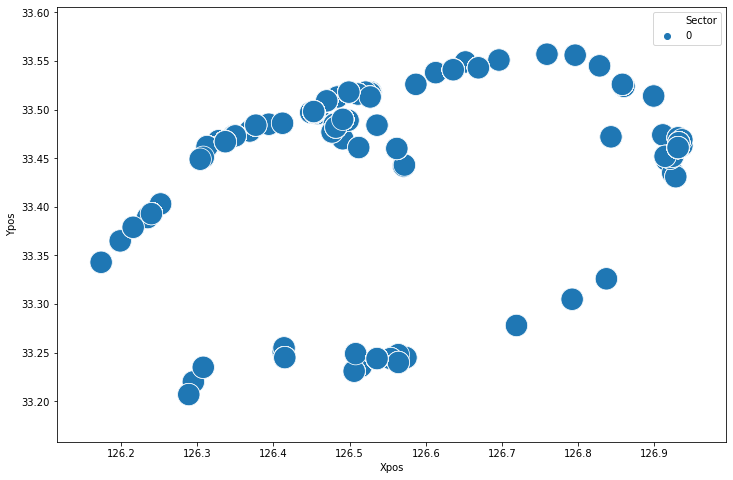

In [25]:
Scatter(OneSector_data)

In [26]:
OneSector_data = OneSector_data.groupby(['rent_date','Sector'],as_index=False).sum()
OneSector_data = WholePreprocessing(OneSector_data)

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


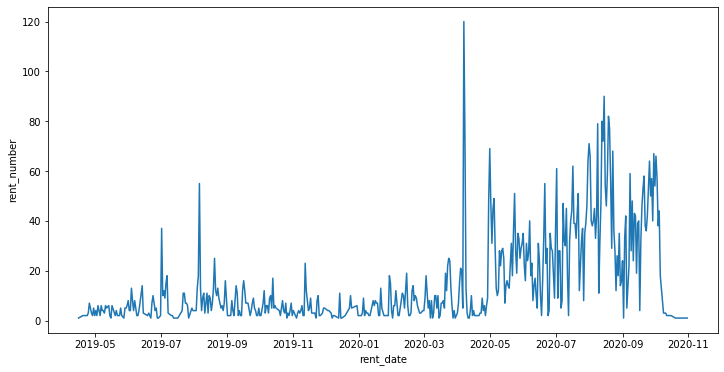

In [27]:
plt.figure(figsize=(12,6))

plt.plot(OneSector_data['rent_date'],OneSector_data['rent_number'])
plt.xlabel('rent_date')
plt.ylabel('rent_number')

plt.show()

In [28]:
OneSector_data

,rent_date,Sector,rent_number,day,T,rain,weekend,weekday_0,weekday_1,weekday_2,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2020
0,2019-04-16,0,1,16,15,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2019-04-20,0,2,20,16,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-04-21,0,2,21,17,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019-04-24,0,2,24,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2019-04-25,0,3,25,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2020-10-15,0,2,15,17,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
481,2020-10-16,0,2,16,16,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
482,2020-10-20,0,1,20,18,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
483,2020-10-21,0,1,21,18,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [29]:
OneSector_data['rain'] = OneSector_data['rain'].astype(str).astype(int)

In [30]:
xlf,X_train,X_test,y_train,y_test = model_training(OneSector_data,0.2)

In [31]:
original_y_test_index,xgb_preds = PrintResult(y_test,xlf,X_test)

RMSE:  12.15704793249536
R2 SCORE 0.65


In [32]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, xgb_preds)

7.917525773195877

In [33]:
def mean_absolute_percentage_error(y_test, xgb_preds): 
    y_test, xgb_preds = np.array(y_test), np.array(xgb_preds)
    return np.mean(np.abs((y_test - xgb_preds) / y_test)) * 100
print(mean_absolute_percentage_error(y_test, xgb_preds))

126.33033414631447


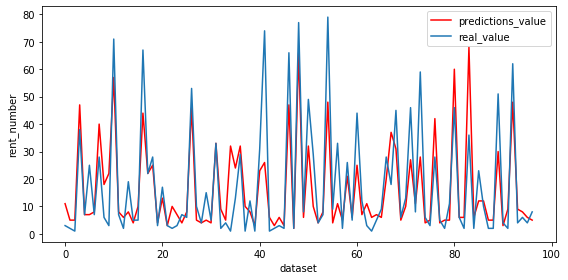

In [34]:
Plot(xgb_preds,y_test)

## Error 추가

In [35]:
One_data_with_error = AddError(X_test,xgb_preds,y_test,original_y_test_index) 

In [36]:
xlf,X_train,X_test,y_train,y_test = model_training(One_data_with_error,0.2)

In [37]:
original_y_test_index,xgb_preds2 = PrintResult(y_test,xlf,X_test)

RMSE:  10.339245620450265
R2 SCORE 0.69


In [38]:
One_data_with_error

,Sector,day,T,rain,weekend,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,...,month_8,month_9,month_10,month_11,month_12,year_2019,year_2020,Minus,rent_number,rent_date
142,0,6,20,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,8,3,None
29,0,24,23,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,3,2,None
0,0,16,15,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,4,1,None
459,0,22,21,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,9,38,None
98,0,18,26,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,7,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,17,22,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,-14,62,None
73,0,21,25,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,5,4,None
312,0,26,13,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2,6,None
302,0,16,14,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2,4,None


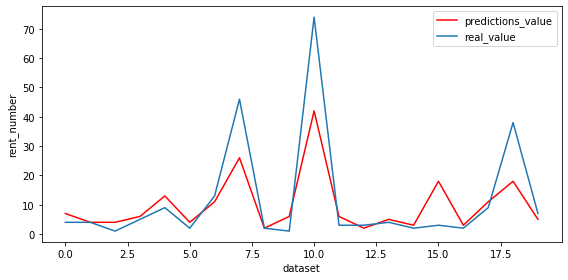

In [39]:
Plot(xgb_preds2,y_test)

# 지역 두개

In [40]:
TwoSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos,Sector
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470,0
1,2019-04-20,2,EVS_000001,20,Saturday,126.499,33.518,0
2,2019-04-21,2,EVS_000001,21,Sunday,126.499,33.518,0
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470,0
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470,0
...,...,...,...,...,...,...,...,...
4726,2020-10-15,2,EVS_000161,15,Thursday,126.636,33.541,0
4727,2020-10-16,2,EVS_000161,16,Friday,126.636,33.541,0
4728,2020-10-20,1,EVS_000206,20,Tuesday,126.931,33.461,0
4729,2020-10-21,1,EVS_000206,21,Wednesday,126.931,33.461,0


In [41]:
for i in range(len(TwoSector_data)):
    if((TwoSector_data['Xpos'].iloc[i] >126.58)):
        TwoSector_data['Sector'].iloc[i] = 0
    else:
        TwoSector_data['Sector'].iloc[i] = 1

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


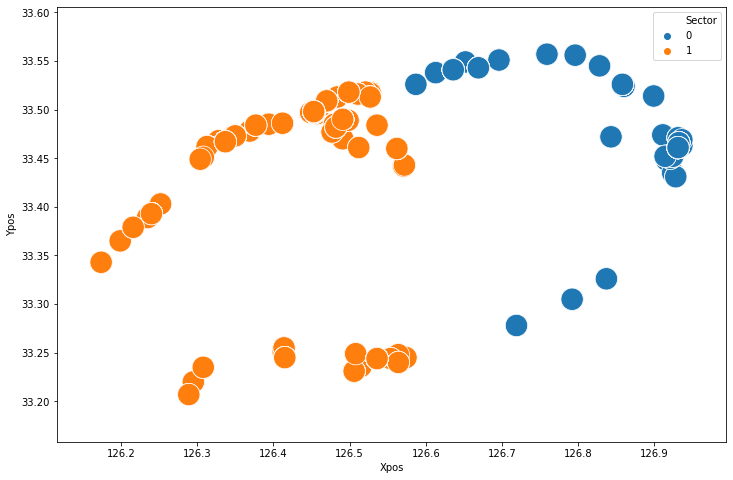

In [42]:
Scatter(TwoSector_data)

In [43]:
TwoSector_data = WholePreprocessing(TwoSector_data)
TwoSector_data

,rent_date,Sector,rent_number,day,T,rain,weekend,weekday_0,weekday_1,weekday_2,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2020
0,2019-04-16,0,1,16,15,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2019-04-20,1,2,20,16,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-04-21,1,2,21,17,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019-04-24,0,2,24,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2019-04-25,0,3,25,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2020-10-15,0,2,15,17,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
735,2020-10-16,0,2,16,16,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
736,2020-10-20,0,1,20,18,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
737,2020-10-21,0,1,21,18,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [44]:
TwoSector_data['rain'] = TwoSector_data['rain'].astype(str).astype(int)

In [45]:
Two_xlf,Two_X_train,Two_X_test,Two_y_train,Two_y_test = model_training(TwoSector_data,0.2)
original_y_test_index,Two_xgb_preds = PrintResult(Two_y_test,Two_xlf,Two_X_test)

RMSE:  7.280109889280518
R2 SCORE 0.66


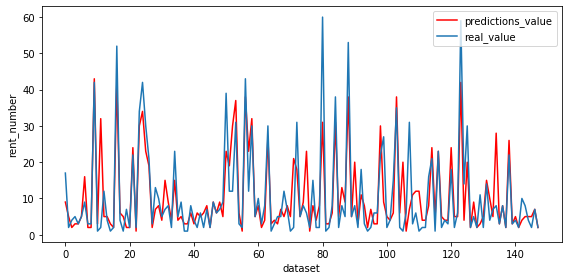

In [46]:
Plot(Two_xgb_preds,Two_y_test)

## Error 추가

In [47]:
Two_data_with_error = AddError(Two_X_test,Two_xgb_preds,Two_y_test,original_y_test_index)

In [48]:
Two_xlf,Two_X_train,Two_X_test,Two_y_train,Two_y_test = model_training(Two_data_with_error,0.2)

In [49]:
original_y_test_index,Two_xgb_preds=PrintResult(Two_y_test,Two_xlf,Two_X_test)

RMSE:  4.396968652757639
R2 SCORE 0.38


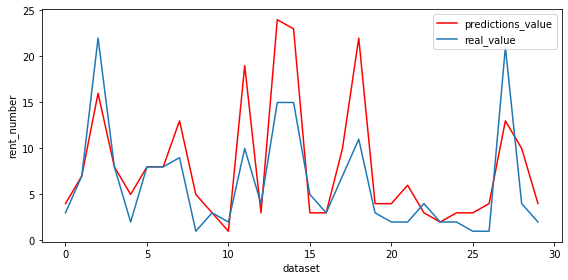

In [50]:
Plot(Two_xgb_preds,Two_y_test)

# 지역 4개

In [51]:
FourSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos,Sector
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470,0
1,2019-04-20,2,EVS_000001,20,Saturday,126.499,33.518,0
2,2019-04-21,2,EVS_000001,21,Sunday,126.499,33.518,0
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470,0
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470,0
...,...,...,...,...,...,...,...,...
4726,2020-10-15,2,EVS_000161,15,Thursday,126.636,33.541,0
4727,2020-10-16,2,EVS_000161,16,Friday,126.636,33.541,0
4728,2020-10-20,1,EVS_000206,20,Tuesday,126.931,33.461,0
4729,2020-10-21,1,EVS_000206,21,Wednesday,126.931,33.461,0


In [52]:
for i in range(len(FourSector_data)):
    if((FourSector_data['Xpos'].iloc[i] <126.58) and (FourSector_data['Ypos'].iloc[i]>33.33)):
        FourSector_data['Sector'].iloc[i] = 0
    elif((FourSector_data['Xpos'].iloc[i] >126.58) and (FourSector_data['Ypos'].iloc[i]>33.33)):
        FourSector_data['Sector'].iloc[i] = 1
    elif((FourSector_data['Xpos'].iloc[i] <=126.6) and (FourSector_data['Ypos'].iloc[i]<=33.33)):
        FourSector_data['Sector'].iloc[i] = 2
    elif((FourSector_data['Xpos'].iloc[i] >=126.6) and (FourSector_data['Ypos'].iloc[i]<=33.33)):
        FourSector_data['Sector'].iloc[i] = 3


C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


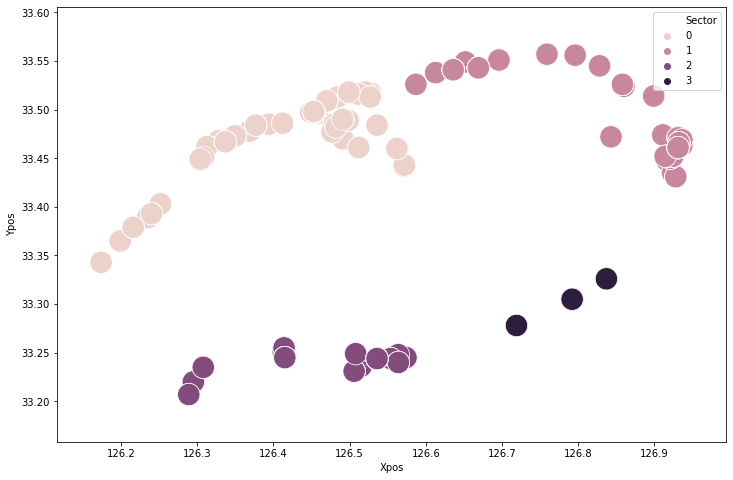

In [53]:
Scatter(FourSector_data)

In [54]:
FourSector_data = WholePreprocessing(FourSector_data)
FourSector_data

,rent_date,Sector,rent_number,day,T,rain,weekend,weekday_0,weekday_1,weekday_2,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2020
0,2019-04-16,1,1,16,15,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2019-04-20,0,2,20,16,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-04-21,0,2,21,17,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019-04-24,1,2,24,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2019-04-25,1,3,25,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,2020-10-15,1,2,15,17,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
881,2020-10-16,1,2,16,16,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
882,2020-10-20,1,1,20,18,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
883,2020-10-21,1,1,21,18,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [55]:
FourSector_data['rain'] = FourSector_data['rain'].astype(str).astype(int)

In [56]:
Four_xlf,Four_X_train,Four_X_test,Four_y_train,Four_y_test = model_training(FourSector_data,0.2)
original_y_test_index,Four_xgb_preds = PrintResult(Four_y_test,Four_xlf,Four_X_test)

RMSE:  5.817371219855625
R2 SCORE 0.71


In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mean_absolute_percentage_error(Four_y_test, Four_xgb_preds))

101.18814725737089


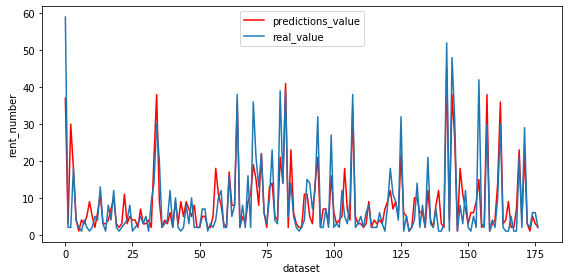

In [58]:
Plot(Four_xgb_preds,Four_y_test)


## Error 추가

In [59]:
Four_data_with_error=AddError(Four_X_test,Four_xgb_preds,Four_y_test,original_y_test_index)
Four_xlf,Four_X_train,Four_X_test,Four_y_train,Four_y_test = model_training(Four_data_with_error,0.2)
original_y_test_index,Four_xgb_preds = PrintResult(Four_y_test,Four_xlf,Four_X_test)

RMSE:  6.426939828219614
R2 SCORE 0.61


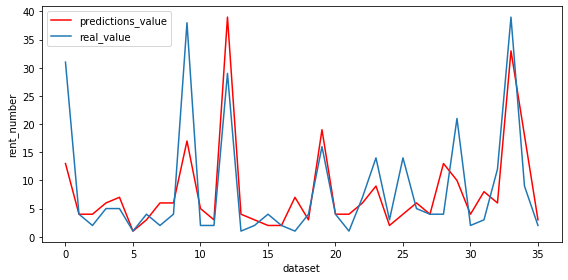

In [60]:
Plot(Four_xgb_preds,Four_y_test)


# 지역 9개

In [61]:
NineSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos,Sector
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470,0
1,2019-04-20,2,EVS_000001,20,Saturday,126.499,33.518,0
2,2019-04-21,2,EVS_000001,21,Sunday,126.499,33.518,0
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470,0
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470,0
...,...,...,...,...,...,...,...,...
4726,2020-10-15,2,EVS_000161,15,Thursday,126.636,33.541,0
4727,2020-10-16,2,EVS_000161,16,Friday,126.636,33.541,0
4728,2020-10-20,1,EVS_000206,20,Tuesday,126.931,33.461,0
4729,2020-10-21,1,EVS_000206,21,Wednesday,126.931,33.461,0


In [62]:
# 126.7<=a , 126.4<a <126.7, 126.4>=   를 나눌 수 있다. 경도 동서
# 33.3>= b, 33.3<b<33.45, 33.45<=b    로 나누자 위도 남북


In [63]:
def SeparateSector(data):
    for i in range(len(data)):
        if((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] <=126.3)):
            data['Sector'].iloc[i] = 0
        elif((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] >=126.3) and (data['Ypos'].iloc[i] <=126.44)):
            data['Sector'].iloc[i] = 1
        elif((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] >=126.44) and (data['Ypos'].iloc[i] <=126.58)):
            data['Sector'].iloc[i] = 2
        elif((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] >=126.58) and (data['Ypos'].iloc[i] <=126.72)):
            data['Sector'].iloc[i] = 3
        elif((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] >=126.72) and (data['Ypos'].iloc[i] <=126.90)):
            data['Sector'].iloc[i] = 4
        elif((data['Xpos'].iloc[i] >33.33) and (data['Ypos'].iloc[i] >=126.90)):
            data['Sector'].iloc[i] = 5
        elif((data['Xpos'].iloc[i] <33.33) and (data['Ypos'].iloc[i] >=126.7)):
            data['Sector'].iloc[i] = 6
        elif((data['Xpos'].iloc[i] <33.33) and (data['Ypos'].iloc[i] >=126.45)) and (data['Ypos'].iloc[i] <=126.7):
            data['Sector'].iloc[i] = 7
        elif((data['Xpos'].iloc[i] <33.33) and (data['Ypos'].iloc[i] <=126.45)):
            data['Sector'].iloc[i] = 8
    return data

In [64]:
NineSector_data['Sector'] = None
NineSector_data = SeparateSector(NineSector_data)

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


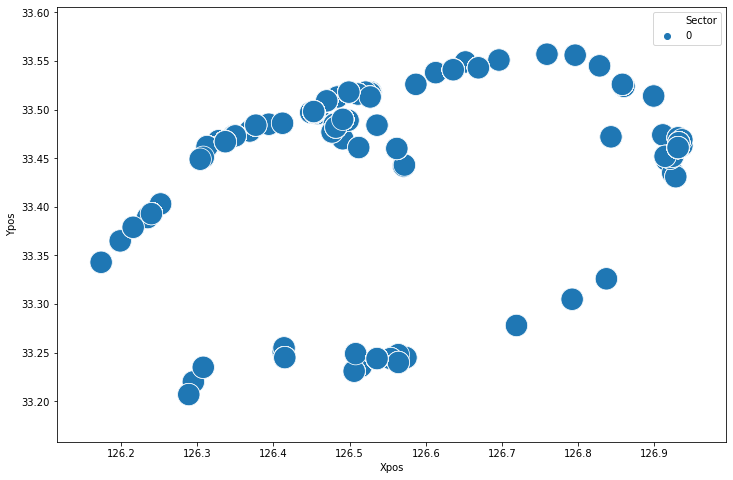

In [65]:
Scatter(NineSector_data)

In [66]:
NineSector_data = WholePreprocessing(NineSector_data)
NineSector_data

,rent_date,Sector,rent_number,day,T,rain,weekend,weekday_0,weekday_1,weekday_2,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2020
0,2019-04-16,0,1,16,15,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2019-04-20,0,2,20,16,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-04-21,0,2,21,17,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019-04-24,0,2,24,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2019-04-25,0,3,25,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2020-10-15,0,2,15,17,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
481,2020-10-16,0,2,16,16,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
482,2020-10-20,0,1,20,18,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
483,2020-10-21,0,1,21,18,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [67]:
NineSector_data['rain'] = NineSector_data['rain'].astype(str).astype(int)

In [68]:
Nine_xlf,Nine_X_train,Nine_X_test,Nine_y_train,Nine_y_test = model_training(NineSector_data,0.3)
original_y_test_index,Nine_xgb_preds = PrintResult(Nine_y_test,Nine_xlf,Nine_X_test)

RMSE:  10.829627044261876
R2 SCORE 0.66


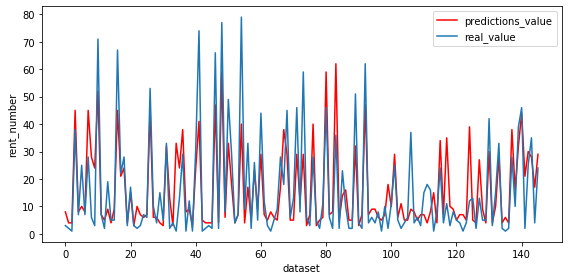

In [69]:
Plot(Nine_xgb_preds,Nine_y_test)

## Error 추가

In [70]:
Nine_data_with_error=AddError(Nine_X_test,Nine_xgb_preds,Nine_y_test,original_y_test_index)
Nine_xlf,Nine_X_train,Nine_X_test,Nine_y_train,Nine_y_test = model_training(Nine_data_with_error,0.3)
original_y_test_index,Nine_xgb_preds = PrintResult(Nine_y_test,Nine_xlf,Nine_X_test)

RMSE:  7.810249675906654
R2 SCORE 0.82


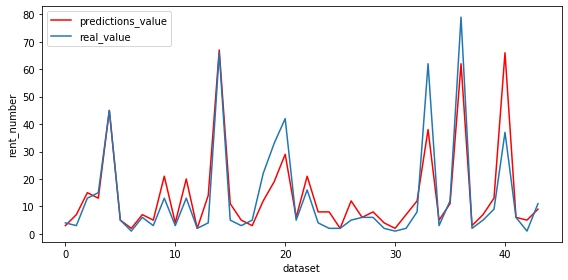

In [71]:
Plot(Nine_xgb_preds,Nine_y_test)